# Project: Topic Classification

_By Isa Chau for W207: Applied Machine Learning, UC Berkeley School of Information Master of Information and Data Science Program (MIDS), Fall 2019._

**This notebook is based on a project I completed for the MIDS program. In summary, we implemented logistic regression models to classify text passages by topic.**

In this project, we work with text data from newsgroup postings on a variety of topics. We train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we represent each document with a "bag-of-words" model. This makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction is useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


In [4]:
#The categories list above is in the wrong order, giving the wrong labels. This code modifies it.
categories = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

### Part 1:

For each of the first 5 training examples, print the text of the message along with the label.

In [5]:
def P1(num_examples=5):
    for n in range(0,num_examples):
        print("label: {0:20} \nmessage: \n{1}\
        \n-------------------------------------------------------"\
              .format(categories[train_labels[n]], train_data[n]))
    
    
P1()


label: comp.graphics        
message: 
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych        
-------------------------------------------------------
label: talk.religion.misc   
message: 


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fr

### Part 2:

Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

* **vocab size: 26879 words**
* **average number of non-zero features per example: 96.71**
* **fraction of entries, nonzero: 0.0036 i.e. 0.36%**

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

* **alphabetical feature strings (first, last): 00, zyxel**

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

* **training vector shape with 4-word vocabulary: (2034, 4)**
* **new average number of non-zero features per example: 0.27**

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

* **vocab size: 32433 bigram and trigram character features**

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

* **vocab size: 3064 words**

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

* **there are 4027 words in dev messages missing from training model vocabulary**
* **fraction of words in dev data missing: 0.248 or 24.8%**

In [6]:
def P2():

    #function to replace line breaks with space
    def remove_line(s):
        return(str(s).replace('\n', ' '))

    #make lower case, remove line breaks from data           
    v_train_data = list(map(str.lower, train_data))
    v_train_data = list(map(remove_line, v_train_data))

    #vectorize training data
    #initialize CountVectorizer
    vectorizer = CountVectorizer()
    
    #fit, transform
    vtrain = vectorizer.fit_transform(v_train_data)

    #part a
    #vocab size
    print("vocab size: {0} words".format(vtrain.shape[1]))
    
    #nonzero features per example = total nonzero entries/total number features
    print("average number of non-zero features per example: {0:.2f}"\
         .format(vtrain.nnz/vtrain.shape[0]))
    
    #fraction of entries that are non-zero = total nonzero entries/total entries
    print("fraction of entries, nonzero: {0:.4f} i.e. {1:.2f}% "\
         .format( vtrain.nnz / ( vtrain.shape[0]*vtrain.shape[1] ),
                  100*vtrain.nnz / ( vtrain.shape[0]*vtrain.shape[1] ) ))
    
    #part b - first and last features, alphabetically
    print("alphabetical feature strings (first, last): {0}, {1}"\
           .format(vectorizer.get_feature_names()[0], vectorizer.get_feature_names()[-1]))
    
    #part c   
    #Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"].
    vtrain_new_vocab = vectorizer.fit(["atheism", "graphics", "space", "religion"])
    vtrain_new_vocab = vectorizer.transform(v_train_data)
    
    #Confirm the training vectors are appropriately shaped.
    print("\nnew four-word vocab defined\ntraining vector shape with 4-word vocabulary: {0}"\
          .format(vtrain_new_vocab.shape))
    
    #Now what's the average number of non-zero features per example?
    print("new average number of non-zero features per example: {0:.2f}"\
         .format(vtrain_new_vocab.nnz/vtrain_new_vocab.shape[0]))
    
    #part d 
    #Extract bigram and trigram character features. 
    vtrain_ngram = CountVectorizer(analyzer = 'char', ngram_range = (2,3)).fit_transform(v_train_data)
    
    #What size vocabulary does this yield?
    print("\nbigram/trigam model trained\
    \nvocab size: {0} bigram and trigram character features".format(vtrain_ngram.shape[1]))
    
    #part e 
    #Use the "min_df" argument to prune words that appear in fewer than 10 documents. 
    vtrain_pruned = CountVectorizer(min_df = 10).fit_transform(v_train_data)
    
    #What size vocabulary does this yield?
    print("\npruned model trained (words appear in >=10 docs)\
    \nvocab size: {0} words".format(vtrain_pruned.shape[1]))
    
    #part f
    #Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? 
    
    #initialize CountVectorizer
    d_vectorizer = CountVectorizer()
    t_vectorizer = CountVectorizer()
    
    #modifying dev data same as training data (lowercase, remove newlines)
    v_dev_data = list(map(str.lower, dev_data))
    v_dev_data = list(map(remove_line, v_dev_data))
    
    #build vocabulary dictionary from training messages
    vtrain = t_vectorizer.fit_transform(v_train_data)
    vtrain_vocab = t_vectorizer.get_feature_names()
    
    #build vocabulary dictionary from dev messages    
    vdev = d_vectorizer.fit_transform(v_dev_data)
    vdev_vocab = d_vectorizer.get_feature_names()
    
    #compare vocabularies for dev words missing in training model
    miss_vocab = [i for i in vdev_vocab if i not in vtrain_vocab]
    miss_vocab_frac = len(miss_vocab) / len(vdev_vocab)
    print("\nthere are {0} words in dev messages missing from training model vocabulary".format(len(miss_vocab)))
    print("fraction of words in dev data missing: {0:.3} or {1:.3}%".format(miss_vocab_frac, miss_vocab_frac*100))

P2()

vocab size: 26879 words
average number of non-zero features per example: 96.71
fraction of entries, nonzero: 0.0036 i.e. 0.36% 
alphabetical feature strings (first, last): 00, zyxel

new four-word vocab defined
training vector shape with 4-word vocabulary: (2034, 4)
new average number of non-zero features per example: 0.27

bigram/trigam model trained    
vocab size: 32433 bigram and trigram character features

pruned model trained (words appear in >=10 docs)    
vocab size: 3064 words

there are 4027 words in dev messages missing from training model vocabulary
fraction of words in dev data missing: 0.248 or 24.8%


### Part 3:

Use the default CountVectorizer options and report the f1 score (use metrics.f1_score with average="weighted") for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

* Why doesn't nearest neighbors work well for this problem?
* Any ideas why logistic regression doesn't work as well as Naive Bayes?
* Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

ANSWER: 
* KNN doesn't work well for this problem because the feature set is large, and the average number of nonzero features per example is very low. KNN will classify an example as closer to another example if they both have zeros for a feature, even though in reality the _lack_ of a specific word is not very informative of the relationship between two messages. For examples that share nonzero features, differences in the number of times a word appears causes the classifier to "see" messages as different, which is generally probably counterproductive to classifying messages.
* Because we have relatively small set of training data compared to a large number of features, logistic regression doesn't work as well as Naive Bayes here. 
* The sum of the squared weight values is directly related to C, and C is the inverse of the regularization parameter $\lambda$ that is multiplied by the sum of squared weights to give the penalty term/regularization term that is added to the cost function in logistic regression. Basically, a smaller C/larger $\lambda$ penalizes the model for having large parameter coefficients, making the model fit the training data less closely.

In [7]:
#help with selecting optimal value for k
#also some formatting stuff
from sklearn.model_selection import GridSearchCV
import pandas as pd
from IPython.display import display, HTML

F1-score for default CountVectorizer and 5-Nearest Neighbor model is 0.417

table showing top 5 k-values:


param_n_neighbors,mean_test_score,rank_test_score
180,0.458206,1
160,0.454256,2
170,0.453770,3
150,0.450807,4
200,0.447891,5


optimal value for k is about 180
f1-score for KNN with k = 180 is 0.469
------------------------------------------------------------

table showing top 5 alpha values:


param_alpha,mean_test_score,rank_test_score
0.01,0.828419,1
0.0001,0.825961,2
0.001,0.825468,3
0.1,0.820550,4
1e-10,0.813678,5


optimal value for alpha is about 0.01
f1-score for Multinomial NB with alpha = 0.01 is 0.784
------------------------------------------------------------

table showing top C values:


param_C,mean_test_score,rank_test_score
0.4,0.765485,1
0.6,0.763518,2
0.5,0.763512,3
0.1,0.763038,4
1,0.759084,5
2,0.754171,6
5,0.749259,7
10,0.748276,8
100,0.742378,9
0.01,0.728142,10


optimal value for C is about 0.4
f1-score for Log Regression with C = 0.4 is 0.704
------------------------------------------------------------
sum of squared weights for each class: [40.42  37.29  42.185 37.329]


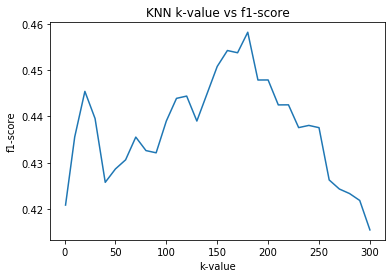

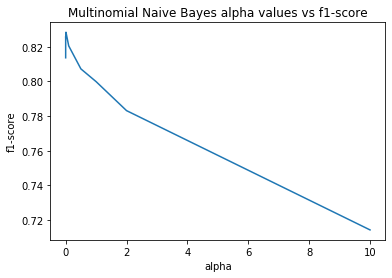

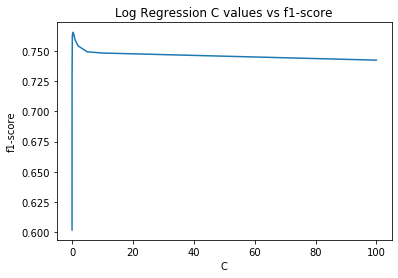

In [8]:
def P3():
    
## Use the default CountVectorizer options and report the f1 score for a KNN classifier ##
## Find the optimal value for k. ##

    #modify data
    #function to replace line breaks with space
    def remove_line(s):
        return(str(s).replace('\n', ' '))

    #make lower case, remove line breaks from data           
    v_train_data = list(map(str.lower, train_data))
    v_train_data = list(map(remove_line, v_train_data))
    
    v_dev_data = list(map(str.lower, dev_data))
    v_dev_data = list(map(remove_line, v_dev_data))
    
    #vectorize training data
    #initialize CountVectorizer
    vectorizer = CountVectorizer()
    
    #fit, transform training data
    #transform dev data
    vtrain = vectorizer.fit_transform(v_train_data)
    vdev = vectorizer.transform(v_dev_data)
    
    #try out KNN, default k = 5
    knn = KNeighborsClassifier(n_neighbors = 5)
    knn.fit(vtrain, train_labels)
    pred_labels_knn = knn.predict(vdev)

    #F1-score for default 5-NN
    knn_default_f1 = metrics.f1_score(pred_labels_knn, dev_labels, average = "weighted")
    print("F1-score for default CountVectorizer and 5-Nearest Neighbor model is {0:.3}".format(knn_default_f1))
    
    #GridSearchCV to try out a lot of k-values
    #use k = 1 and k = multiples of 10 up to 300
    k_values = {'n_neighbors': np.insert(np.arange(10, 310, 10).tolist(),0,[1])}
    #k_values = {'n_neighbors': [1,2,3,4,5]} test values
    
    choose_k = GridSearchCV(KNeighborsClassifier(), param_grid = k_values, iid = False, cv = 5, n_jobs = -1)
    k_fit = choose_k.fit(vtrain, train_labels)
    k_results = pd.DataFrame(choose_k.cv_results_)
    sorted_k_results = (k_results.iloc[:,[4,11,13]].sort_values(by='rank_test_score')).head(n=5)
    print("\ntable showing top 5 k-values:")
    display(HTML(sorted_k_results.to_html(index=False, table_id = 'test')))
    
    #a little sketch of k-value vs f1 score
    fig = plt.figure()
    ax = plt.axes()
    x = k_results.iloc[:,4]
    y = k_results.iloc[:,11]
    ax.plot(x,y)
    plt.title("KNN k-value vs f1-score")
    plt.xlabel("k-value")
    plt.ylabel("f1-score");
    
    best_k = x[np.argmax(np.array(y))]
    
    #show optimal value for k
    print("optimal value for k is about {0}".format(best_k))
    
    #use optimal value in model, report f1-score
    knn = KNeighborsClassifier(n_neighbors = best_k)
    knn.fit(vtrain, train_labels)
    pred_labels_knn = knn.predict(vdev)
    knn_f1 = metrics.f1_score(pred_labels_knn, dev_labels, average = "weighted")
    print("f1-score for KNN with k = {0} is {1:.3}".format(best_k, knn_f1))
    print("-"*60)
    
## Fit a Multinomial Naive Bayes model and find the optimal value for alpha. ##
    
    #MultinomialNB
    #GridSearchCV to try out a lot of alphas
    alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
    choose_alpha = GridSearchCV(MultinomialNB(), param_grid = alphas, iid = False, cv = 5, n_jobs = -1)
    alpha_fit = choose_alpha.fit(vtrain, train_labels)
    alpha_results = pd.DataFrame(choose_alpha.cv_results_)
    sorted_alpha_results = (alpha_results.iloc[:,[4,11,13]].sort_values(by='rank_test_score')).head(n=5)
    print("\ntable showing top 5 alpha values:")
    display(HTML(sorted_alpha_results.to_html(index=False)))
    
    #a little sketch of alpha vs f1 score
    fig2 = plt.figure()
    ax2 = plt.axes()
    x2 = alpha_results.iloc[:,4]
    y2 = alpha_results.iloc[:,11]
    ax2.plot(x2,y2)
    plt.title("Multinomial Naive Bayes alpha values vs f1-score")
    plt.xlabel("alpha")
    plt.ylabel("f1-score");
    
    best_alpha = x2[np.argmax(np.array(y2))]
    
    #show optimal value for k
    print("optimal value for alpha is about {0}".format(best_alpha))
    
    #use optimal value in model, report f1-score
    NB = MultinomialNB(alpha = best_alpha, fit_prior = True)
    NB.fit(vtrain, train_labels)
    pred_labels_NB = NB.predict(vdev)
    NB_f1 = metrics.f1_score(pred_labels_NB, dev_labels, average = "weighted")
    print("f1-score for Multinomial NB with alpha = {0} is {1:.3}".format(best_alpha, NB_f1))
    print("-"*60)
    
## Finally, fit a logistic regression model 
## and find the optimal value for the regularization strength C using l2 regularization.
    
    #log regression
    #GridSearchCV to try out a lot of regularization strengths C
    C = {'C': [0.001, 0.01, 0.1, 0.4, 0.5, 0.6, 1.0, 2.0, 5, 10, 100]}
    choose_C = GridSearchCV(LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000), param_grid = C, iid = False, cv = 5, n_jobs = -1)
    C_fit = choose_C.fit(vtrain, train_labels)
    C_results = pd.DataFrame(choose_C.cv_results_)
    sorted_C_results = (C_results.iloc[:,[4,11,13]].sort_values(by='rank_test_score')).head(n=10)
    print("\ntable showing top C values:")
    display(HTML(sorted_C_results.to_html(index=False)))
    
    #a little sketch of C vs f1 score
    fig3 = plt.figure()
    ax3 = plt.axes()
    x3 = C_results.iloc[:,4]
    y3 = C_results.iloc[:,11]
    ax3.plot(x3,y3)
    plt.title("Log Regression C values vs f1-score")
    plt.xlabel("C")
    plt.ylabel("f1-score");
    
    best_C = x3[np.argmax(np.array(y3))]
    
    #show optimal value for k
    print("optimal value for C is about {0}".format(best_C))
    
    #use optimal value in model, report f1-score
    
    LR = LogisticRegression(C = best_C, solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
    LR.fit(vtrain, train_labels)
    pred_labels_LR = LR.predict(vdev)
    LR_f1 = metrics.f1_score(pred_labels_LR, dev_labels, average = "weighted")
    print("f1-score for Log Regression with C = {0} is {1:.3}".format(best_C, LR_f1))
    print("-"*60)
    
    #Logistic regression estimates a weight vector for each class, 
    #which you can access with the coef_ attribute. 
    #Output the sum of the squared weight values for 
    #each class for each setting of the C parameter.
    #Briefly explain the relationship between the sum and the value of C.
    
    squared_weights = []
    for i in range(4):
        squared_list = map(lambda x: x**2 , LR.coef_[i])
        squared_weights.append(sum(squared_list))
        
    squared_weights = np.around(np.array(squared_weights),3)
    print("sum of squared weights for each class: {0}".format(squared_weights))
    
P3()

### Part 4:

Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

ANSWER: With the unigram feature model, the strongest weighted features are mostly words that seem to be related to the category of the message. However, with the bigram feature model, some features seem not very related to the category of the message (e.g. the features "is there", "it was", "and such"). Something funny is that "Cheers Kent"--which I assume is user Kent signing off of messages--is common enough to be in the top 5 weighted features for both the atheism and religion message boards. I guess he was really active in those communities.

In [9]:
def P4():
    #modify data
    #function to replace line breaks with space
    def remove_line(s):
        return(str(s).replace('\n', ' '))

    #make lower case, remove line breaks from data           
    v_train_data = list(map(str.lower, train_data))
    v_train_data = list(map(remove_line, v_train_data))
    
    v_dev_data = list(map(str.lower, dev_data))
    v_dev_data = list(map(remove_line, v_dev_data))
    
    #vectorize training data
    #initialize CountVectorizer
    vectorizer = CountVectorizer()
    
    #fit, transform training data
    #transform dev data
    vtrain = vectorizer.fit_transform(v_train_data)
    vdev = vectorizer.transform(v_dev_data)

    #Logistic Regression
    #train the model
    LR = LogisticRegression(C = 0.5, solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
    LR.fit(vtrain, train_labels)
    
    #create table of features with largest weights for each of 4 labels
    weights_table = []
    index_labels = [] #to save the feature names to show on our table
    for i in range(4):
        five_max = sorted(LR.coef_[i],reverse = True)[:5] #find 5 largest weights in each label i
        for n in five_max:
            max_id = np.where(LR.coef_[i] == n)[0].item() #find index of highly weighted feature
            new_row = [ LR.coef_[0][max_id].item(), #find weight of the feature for all 4 labels
                        LR.coef_[1][max_id].item(), 
                        LR.coef_[2][max_id].item(), 
                        LR.coef_[3][max_id].item() ]
            weights_table.append(new_row) #add new row of weights--1 feature x 4 labels
            index_labels.append( vectorizer.get_feature_names()[max_id] ) #add feature name to index we're building
    
    #create table, display with index of feature names and label names as columns
    weights_pd = pd.DataFrame(weights_table, index = index_labels, columns = categories)
    print("Weights Table for Regular Log Regression")
    display(weights_pd)
    
    
    #logistic regression with bigram features
    #vectorize our data for bigram (word) features
    #train the model
    bigram_vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (2,2))
    bigram_vtrain = bigram_vectorizer.fit_transform(v_train_data)
    bigram_LR = LogisticRegression(C = 0.5, solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
    bigram_LR.fit(bigram_vtrain, train_labels)
    
    #create table of features with largest weights for each of 4 labels
    weights_table = []
    index_labels = [] #to save the feature names to show on our table
    for i in range(4):
        five_max = sorted(bigram_LR.coef_[i],reverse = True)[:5] #find 5 largest weights in each label i
        for n in five_max:
            max_id = np.where(bigram_LR.coef_[i] == n)[0].item() #find index of highly weighted feature
            new_row = [ bigram_LR.coef_[0][max_id].item(), #find weight of the feature for all 4 labels
                        bigram_LR.coef_[1][max_id].item(), 
                        bigram_LR.coef_[2][max_id].item(), 
                        bigram_LR.coef_[3][max_id].item() ]
            weights_table.append(new_row) #add new row of weights--1 feature x 4 labels
            index_labels.append( bigram_vectorizer.get_feature_names()[max_id] ) #add feature name to index we're building
    
    #create table, display with index of feature names and label names as columns
    weights_bigram_pd = pd.DataFrame(weights_table, index = index_labels, columns = categories)
    
    print("Weights Table for Log Regression with Bigram Features")
    display(weights_bigram_pd)
    
P4()

Weights Table for Regular Log Regression


,alt.atheism,comp.graphics,sci.space,talk.religion.misc
religion,0.634659,-0.331849,-0.424535,0.121726
deletion,0.619064,-0.217936,-0.228597,-0.172531
atheists,0.609557,-0.055051,-0.173276,-0.381230
atheism,0.576432,-0.233140,-0.235738,-0.107555
bobby,0.523254,-0.121522,-0.174737,-0.226996
graphics,-0.310228,1.182715,-0.580919,-0.291568
image,-0.268595,0.841562,-0.364402,-0.208565
file,-0.126925,0.787364,-0.366790,-0.293649
3d,-0.159022,0.658702,-0.327273,-0.172407
files,-0.261244,0.573576,-0.035215,-0.277117


Weights Table for Log Regression with Bigram Features


,alt.atheism,comp.graphics,sci.space,talk.religion.misc
cheers kent,0.455390,-0.464132,-0.436861,0.445603
claim that,0.439275,-0.149920,-0.194078,-0.095278
you are,0.401461,-0.168631,-0.326428,0.093599
was just,0.387034,-0.114554,-0.104576,-0.167904
look up,0.355099,-0.138099,-0.118315,-0.098685
looking for,-0.355704,0.861601,-0.180827,-0.325071
in advance,-0.235314,0.636775,-0.182753,-0.218708
comp graphics,-0.188233,0.610068,-0.229233,-0.192601
is there,-0.195899,0.586761,-0.249813,-0.141049
out there,-0.137269,0.555727,-0.267253,-0.151205


### Part 5:

Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [10]:
# Turns out I was already preprocessing the raw text a bit in parts 1-4

def empty_preprocessor(s):
    return s

def better_preprocessor(s):
    #make lower case
    s = str.lower(s)
    #function to replace line breaks with space
    s = str(s).replace('\n', ' ')
    #remove special characters
    s = re.sub('[^A-Za-z0-9 _\-@?!]+', ' ', s)
    #remove any length sequence of numbers followed by x
    s = re.sub('[0-9]{,}x', '', s)
    #remove words less than 3 char
    s = re.sub(r'\b\w{1,4}\b', '', s)
    
    #note: i think most/all of my F1 improvement was from removing small words
    return s
    
def P5():
    
    #initialize CountVectorizer
    raw_vectorizer = CountVectorizer(preprocessor = empty_preprocessor)
    raw_train = raw_vectorizer.fit_transform(train_data)
    raw_dev = raw_vectorizer.transform(dev_data)
    #print (vectorizer.get_feature_names())
    print ("raw vocab size: ", raw_train.shape[1])
    
    #initialize CountVectorizer
    vectorizer = CountVectorizer(preprocessor = better_preprocessor)
    vtrain = vectorizer.fit_transform(train_data)
    vdev = vectorizer.transform(dev_data)
    #print (vectorizer.get_feature_names())
    print ('processed vocab size: ', vtrain.shape[1])
    
    #model on raw data, print f1
    raw_LR = LogisticRegression(C = 0.5, solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
    raw_LR.fit(raw_train, train_labels)
    raw_pred_labels_LR = raw_LR.predict(raw_dev)
    raw_LR_f1 = metrics.f1_score(raw_pred_labels_LR, dev_labels, average = "weighted")
    print("f1-score for Log Regression, raw data: {0:.5}".format(raw_LR_f1))
    
    #model on preprocessed data, print f1
    LR = LogisticRegression(C = 0.5, solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
    LR.fit(vtrain, train_labels)
    pred_labels_LR = LR.predict(vdev)
    LR_f1 = metrics.f1_score(pred_labels_LR, dev_labels, average = "weighted")
    print("f1-score for Log Regression, preprocessed data: {0:.5}".format(LR_f1))
    print("\nf1-score on dev set improved by {0:.3} points".format(((LR_f1 - raw_LR_f1)*100)))
    
    #compare vocabularies
    voc_red = raw_train.shape[1] - vtrain.shape[1]
    voc_red_percent = voc_red / raw_train.shape[1] * 100
    print("new preprocessor reduced vocab size by {0} words, or {1:.3}%".format(voc_red, voc_red_percent))
    
P5()

raw vocab size:  33291
processed vocab size:  20957
f1-score for Log Regression, raw data: 0.70974
f1-score for Log Regression, preprocessed data: 0.73433

f1-score on dev set improved by 2.46 points
new preprocessor reduced vocab size by 12334 words, or 37.0%


### Part 6:

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).

In [11]:
#for converting array back to CSR matrix
from scipy import sparse

log regression with l1 penalty yields 970 nonzero learned weights
log regression with l2 penalty yields 83828 nonzero learned weights
f1-score of model with l2 penalty using nonzero features from l1: 0.61765


C:\Users\Isaac\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


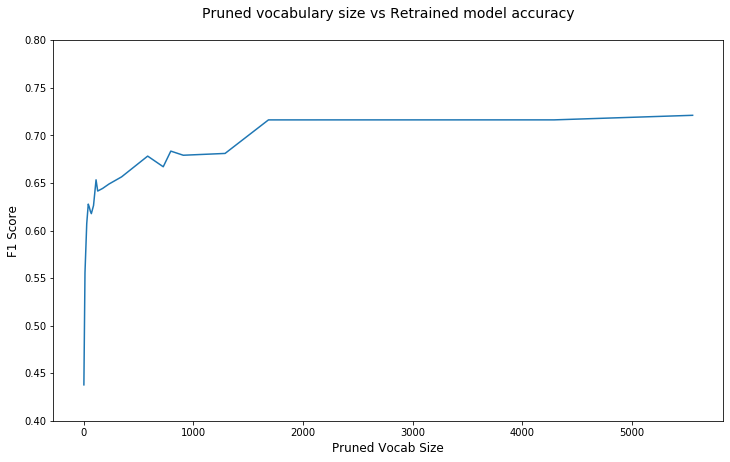

In [12]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    #using preprocessor from part 5
    vectorizer = CountVectorizer(preprocessor = better_preprocessor)
    vtrain = vectorizer.fit_transform(train_data)
    vdev = vectorizer.transform(dev_data)
    
    #model with l1 penalty
    LR1 = LogisticRegression(penalty = 'l1', C = 0.5, multi_class = 'auto', max_iter = 1000, solver = 'liblinear')
    LR1.fit(vtrain, train_labels)
    
    #count nonzero feature weights
    l1_nz_count = np.count_nonzero(LR1.coef_)
    print("log regression with l1 penalty yields {0} nonzero learned weights".format(l1_nz_count))
    
    #model with l2 penalty
    LR2 = LogisticRegression(penalty = 'l2', C = 0.5, multi_class = 'auto', max_iter = 1000, solver = 'lbfgs')
    LR2.fit(vtrain, train_labels)
    
    #count nonzero feature weights
    l2_nz_count = np.count_nonzero(LR2.coef_)
    print("log regression with l2 penalty yields {0} nonzero learned weights".format(l2_nz_count))
    
    #find indices of zero'ed out features
    zero_id = list(np.array(np.where(LR1.coef_ == 0)[1]))
    #nonzero_id = np.array(np.nonzero(LR1.coef_))[1]
    
    #print(len(set(zero_id))
    #20915 unique features in zero_id
    
    #csr to array, delete columns, then back to csr to use in LR
    vtrain_array = vtrain.toarray()
    vdev_array = vdev.toarray()
    nonzero_vtrain_array = np.delete(vtrain_array, [zero_id], axis = 1)
    nonzero_vdev_array = np.delete(vdev_array, [zero_id], axis = 1)
    
    #back to csr
    vtrain_nonzero = sparse.csr_matrix(nonzero_vtrain_array)
    vdev_nonzero = sparse.csr_matrix(nonzero_vdev_array)
    
    #fit l2 model with chosen l1 features
    LR2.fit(vtrain_nonzero, train_labels)
    pred_labels_LR2 = LR2.predict(vdev_nonzero)
    LR_f1 = metrics.f1_score(pred_labels_LR2, dev_labels, average = "weighted")
    print("f1-score of model with l2 penalty using nonzero features from l1: {0:.5}".format(LR_f1))
    
    #figure dimensions
    plt.figure(figsize =(12,7))
    #############################
    
    #initialize lists to store our results
    LR_f1 = []
    vocab_size = []
    #C values to try
    C_val = [0.01, 0.1, 0.2, 0.5, 0.6, 0.75, 1, 1.5, 2, 3, 4, 5, 10, 15, 20, 25, 30, 50, 100, 500, 1000]
    
    #define LR with l2 outside of loop since it won't be changing
    LR2 = LogisticRegression(penalty = 'l2', C = 0.5, multi_class = 'auto', max_iter = 1000, solver = 'lbfgs', tol = 0.015)

    for test_C in C_val:
        LR1 = LogisticRegression(penalty = 'l1', C = test_C, multi_class = 'auto', max_iter = 1000, tol = 0.015, solver = 'liblinear')
        LR1.fit(vtrain, train_labels)
        
        #find indices of zero'ed out features
        zero_id = list(np.array(np.where(LR1.coef_ == 0)[1])) 
        
        #csr to array, delete columns, then back to csr to use in LR
        vtrain_array = vtrain.toarray()
        vdev_array = vdev.toarray()
        nonzero_vtrain_array = np.delete(vtrain_array, [zero_id], axis = 1)
        nonzero_vdev_array = np.delete(vdev_array, [zero_id], axis = 1)
        #back to csr
        vtrain_nonzero = sparse.csr_matrix(nonzero_vtrain_array)
        vdev_nonzero = sparse.csr_matrix(nonzero_vdev_array)
        
        #fit l2 model with chosen l1 features
        LR2.fit(vtrain_nonzero, train_labels)
        pred_labels_LR2 = LR2.predict(vdev_nonzero)
        
        #add f1 and vocab size to list
        LR_f1.append(metrics.f1_score(pred_labels_LR2, dev_labels, average = "weighted"))
        vocab_size.append( int(vtrain_nonzero.shape[1]) )         
        
    #plot our data
    plt.title('Pruned vocabulary size vs Retrained model accuracy\n', fontsize=14, fontdict=None, loc='center', pad=None,)
    plt.plot(vocab_size,LR_f1, label = 'vocab size vs accuracy') #label for legend
    plt.xlabel('Pruned Vocab Size', fontsize = 12)
    plt.ylabel('F1 Score',fontsize = 12)
    plt.ylim(0.4,0.8)
    
    #was going to annotate with C-values but it got too messy
#     for i, txt in enumerate(C_val):
#         plt.annotate(txt, (vocab_size[i], LR_f1[i]) )
#     #plt.legend(loc = 4)
P6()

### Part 7:

Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

ANSWER: TFidfVectorizer is equivalent to CountVectorizer followed by TfidfTransformer. Tf-idf stands for term-frequency times inverse document-frequency. TFidfVectorizer reduces the weight of features that occur very frequently throughout the data because they are less informative than features that occur only in a small fraction of the data.

Two of the three messages are from the 'religion' category but were predicted incorrectly to be 'graphics'. It seems like the words stemming from the technical nature of the messages (words I assume would be associated with technology like 'ftp', 'Apple', 'RTF', 'ASCII', etc) had a greater effect on the prediction than the religious-associated words, like 'Mormon'. This makes sense given how I understand TFidfVectorizer to work -- words that are more unlikely to be found in the general corpus of data (like 'ASCII', 'ftp', 'Mormon') affect the classification more. The message with the largest ratio R that we defined was very long, with many words repeated; maybe only counting a feature once for a message no matter how many times a feature is repeated could help reduce this bias. For another approach, "Book of Mormon" could definitely be a strong, rare feature for predicting a 'religion' label -- adding bigram/trigram/n-gram features would probably improve prediction in these cases. 

In [21]:
def P7():

    #vectorize data
    vectorizer = TfidfVectorizer()
    vtrain = vectorizer.fit_transform(train_data)
    vdev = vectorizer.transform(dev_data)
    
    #train model
    LR = LogisticRegression(C = 100, multi_class = 'auto', max_iter = 1000, solver = 'liblinear')
    LR.fit(vtrain, train_labels)
    pred_labels = LR.predict(vdev)
    print("f1 score using Log Regression with TFidfVectorizer: {0:.4}\n".format(metrics.f1_score(pred_labels, dev_labels, average = "weighted")))
    
    proba = LR.predict_proba(vdev)
    
    R = []
    for row in range(0,len(proba)):
        R.append( max(proba[row]) / proba[row][ (dev_labels[row]) ] )
    
    
    for n in sorted(R,reverse = True)[:3]:
        R_id = np.where(R == n)[0].item()
        print("label: {0:20} \npredicted label: {2}\nratio max predicted prob/predict prob of correct label: {3:.5}\n\nmessage: \n{1}\
        \n------------------------------------------------------------------------------"\
              .format(categories[dev_labels[R_id]], dev_data[R_id], categories[pred_labels[R_id]], R[R_id]))
    
    
P7()

f1 score using Log Regression with TFidfVectorizer, 1-,2-, and 3-gram features: 0.7669

label: talk.religion.misc   
predicted label: comp.graphics
ratio max predicted prob/predict prob of correct label: 929.36

message: 
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (pape

### Part 8 EXTRA CREDIT:

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

In [23]:
def P8():
#attempting to use unigram, bigram, and trigram features 
#vectorize data
    vectorizer = TfidfVectorizer(ngram_range = (1,3))
    vtrain = vectorizer.fit_transform(train_data)
    vdev = vectorizer.transform(dev_data)
    
    #train model
    LR = LogisticRegression(C = 100, multi_class = 'auto', max_iter = 1000, solver = 'liblinear')
    LR.fit(vtrain, train_labels)
    pred_labels = LR.predict(vdev)
    print("f1 score of Log Regression with TFidfVectorizer (1-, 2-, 3-gram features): {0:.4}\n".format(metrics.f1_score(pred_labels, dev_labels, average = "weighted")))

    proba = LR.predict_proba(vdev)
    
    R = []
    for row in range(0,len(proba)):
        R.append( max(proba[row]) / proba[row][ (dev_labels[row]) ] )
    
    
    for n in sorted(R,reverse = True)[:3]:
        R_id = np.where(R == n)[0].item()
        print("label: {0:20} \npredicted label: {2}\nratio max predicted prob/predict prob of correct label: {3:.5}\n\nmessage: \n{1} ...\
        \n------------------------------------------------------------------------------"\
              .format(categories[dev_labels[R_id]], dev_data[R_id][:300], categories[pred_labels[R_id]], R[R_id]))

P8()

f1 score of Log Regression with TFidfVectorizer (1-, 2-, 3-gram features): 0.7577

label: talk.religion.misc   
predicted label: comp.graphics
ratio max predicted prob/predict prob of correct label: 669.72

message: 
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages ...        
------------------------------------------------------------------------------
label: talk.religion.misc   
predicted label: alt.atheism
ratio max predicted prob/predict prob of correct label: 285.61

message: 
In <1ren9a$94q@morrow.stanford.edu> salem@pangea.Stanford.EDU (Bruce Salem) 



This brings up another something I have never understood.  I asked this once
before and got a few interesting responses, but somehow didn't seem satisfied.
Why would the NT NOT be

So adding bigram and trigram word features to our model reduced the largest R ratios for mislabeled messages. Great! And 2 of the 3 messages with the highest R have changed. But it reduced our f1 score by about a point. What if we I preprocessed the data a little?

In [24]:
def P8():
#attempting to use unigram, bigram, and trigram features 
#vectorize data
    vectorizer = TfidfVectorizer(preprocessor = better_preprocessor, ngram_range = (1,3))
    vtrain = vectorizer.fit_transform(train_data)
    vdev = vectorizer.transform(dev_data)
    
    #train model
    LR = LogisticRegression(C = 100, multi_class = 'auto', max_iter = 1000, solver = 'liblinear')
    LR.fit(vtrain, train_labels)
    pred_labels = LR.predict(vdev)
    print("f1 score, Log Regression, TFidfVectorizer (1,2,3-gram, preprocessed): {0:.4}\n".format(metrics.f1_score(pred_labels, dev_labels, average = "weighted")))

    proba = LR.predict_proba(vdev)
    
    R = []
    for row in range(0,len(proba)):
        R.append( max(proba[row]) / proba[row][ (dev_labels[row]) ] )
    
    
    for n in sorted(R,reverse = True)[:3]:
        R_id = np.where(R == n)[0].item()
        print("label: {0:20} \npredicted label: {2}\nratio max predicted prob/predict prob of correct label: {3:.5}\n\nmessage: \n{1} ...\
        \n------------------------------------------------------------------------------"\
              .format(categories[dev_labels[R_id]], dev_data[R_id][:300], categories[pred_labels[R_id]], R[R_id]))

P8()

f1 score, Log Regression, TFidfVectorizer (1,2,3-gram, preprocessed): 0.78

label: talk.religion.misc   
predicted label: comp.graphics
ratio max predicted prob/predict prob of correct label: 303.98

message: 
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages ...        
------------------------------------------------------------------------------
label: alt.atheism          
predicted label: sci.space
ratio max predicted prob/predict prob of correct label: 235.68

message: 

The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...
 ...        
------------------------------------------------------------------------------
label: talk.religion.misc   
predicte

Our new f1 score is 0.78, more than a point higher than it was in Part 7. The largest R ratios (maximum predicted probability / predicted probability of the correct label) of our mislabeled data are also greatly reduced compared to Part 7. Nice!